# Load e imports

In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [226]:
df = pd.read_csv('data_balanced.csv', encoding='utf-8')

In [227]:
df['result'].value_counts()

result
1    63910
0    63910
Name: count, dtype: int64

# Avaliando modelo por liga

## Preprocessamento

In [228]:
# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
        ],
        remainder='passthrough'  # Mantém as características categóricas sem transformação
    )
    return preprocessor.fit(X)

## Treinamento

In [229]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score

# Lista das ligas únicas no conjunto de dados
leagues = df['league'].unique()

# Dicionário para armazenar histórico de treinamento e avaliação para cada liga
league_histories = {}

# Loop por cada liga para criar, treinar e avaliar um modelo separado
t = len(leagues)
for league in leagues:
    print(f"Treinando modelo para a liga: {league} ({t} ligas restantes)")
    t -= 1
    
    # Filtrando o conjunto de dados para apenas a liga atual
    league_data = df[df['league'] == league]
    
    # Preparando os dados de entrada e saída
    X = league_data.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1)
    y = league_data['result']

    preprocessor = create_preprocessor(X)
    X_transformed = preprocessor.transform(X)

    weight_calss_0 = (len(y) - y.sum()) / len(y)
    weight_calss_1 = y.sum() / len(y)

    class_weight = {0: weight_calss_0/2, 1: weight_calss_1*2}

    
    model_randomf = RandomForestClassifier(
                                            n_estimators=100, 
                                            random_state=42, 
                                            min_samples_split=5, 
                                            min_samples_leaf=2, 
                                            # class_weight=class_weight
                                        )

    # Validação cruzada
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='roc_auc')
    print(f"Média AUC para {league}: {cv_scores.mean()}")

    # acuracia
    cv_scores = cross_val_score(model_randomf, X_transformed, y, cv=5, scoring='accuracy')
    print(f"Média Acurácia para {league}: {cv_scores.mean()}")

    # Treinando e avaliando o modelo
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_randomf.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model_randomf.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model_randomf.predict_proba(X_test)[:, 1])

    feature_importance = model_randomf.feature_importances_

    # Armazenando a avaliação em um dicionário
    league_histories[league] = {
        'cv_auc_mean': cv_scores.mean(),
        'train_auc': train_auc,
        'test_auc': test_auc,
        'feature_importance': feature_importance
    }

    # Predicting the values
    y_pred = model_randomf.predict(X_test)
    
    # classification report
    print(classification_report(y_test, y_pred))
    print()

Treinando modelo para a liga: South America - Copa Libertadores (33 ligas restantes)
Média AUC para South America - Copa Libertadores: 0.3745737098684258
Média Acurácia para South America - Copa Libertadores: 0.38274932614555257
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       353
           1       0.89      0.95      0.92       389

    accuracy                           0.91       742
   macro avg       0.92      0.91      0.91       742
weighted avg       0.91      0.91      0.91       742


Treinando modelo para a liga: Asia - AFC Champions League (32 ligas restantes)
Média AUC para Asia - AFC Champions League: 0.3609858738586232
Média Acurácia para Asia - AFC Champions League: 0.36264447526583454
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       344
           1       0.92      0.94      0.93       377

    accuracy                           0.93       721
   macro avg  

## Avaliando importancia das features de cada liga

In [230]:
dataframe_league = pd.DataFrame.from_dict(league_histories, orient='index')
dataframe_league

,cv_auc_mean,train_auc,test_auc,feature_importance
South America - Copa Libertadores,0.382749,0.999393,0.972502,"[0.07891269104175486, 0.006603710435350812, 0...."
Asia - AFC Champions League,0.362644,0.999138,0.979520,"[0.0896344962513609, 0.003002269837727797, 0.0..."
Brazil - Paulista A1,0.380486,0.999464,0.967557,"[0.07803851931257133, 0.0013147981209671888, 0..."
South America - Copa Sudamericana,0.436641,0.999200,0.970434,"[0.07281674727845176, 0.0026806659115366626, 0..."
Japan - J-League,0.343613,0.999506,0.974702,"[0.08792636559003475, 0.005523611812733617, 0...."
USA - Major League Soccer,0.309421,0.999387,0.960138,"[0.08717177562211835, 0.008213917603004162, 0...."
Mexico - Liga MX,0.351772,0.999461,0.969261,"[0.08328206238742404, 0.005643271031652499, 0...."
Scotland - Premiership,0.354772,0.999276,0.956258,"[0.07591775511339233, 0.0017952028557940444, 0..."
Brazil - Serie A,0.363083,0.999456,0.978681,"[0.08365686716007167, 0.008685283696852545, 0...."
France - Ligue 1,0.374421,0.999195,0.968526,"[0.07732521716301288, 0.005520761336648997, 0...."


In [231]:
# Calculando a média da importância de cada característica em todas as ligas
mean_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist()).mean().tolist()

# Convertendo a lista de importâncias das características em um DataFrame para facilitar a análise
df_feature_importances = pd.DataFrame(dataframe_league['feature_importance'].tolist())

# Calculando a variância da importância de cada característica em todas as ligas
feature_variances = df_feature_importances.var()

# Criando um DataFrame resumo para conter os dados de variância e correlação
summary_df = pd.DataFrame({
    'Mean Importance': mean_feature_importances,
    'Variance': feature_variances,
})

# Exibindo o DataFrame resumo ordenado por variância para ver quais características têm mais variabilidade entre as ligas
summary_df.sort_values('Variance', ascending=False, inplace=True)
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Feature'}, inplace=True)

feature_names = df.drop(['result', 'league', 'homeTeam', 'awayTeam', 'match_id'], axis=1).columns
# feature_names = df.drop(['result', 'league'], axis=1).columns

# Mapeando os números para os nomes das características
summary_df['Feature Name'] = summary_df['Feature'].apply(lambda x: feature_names[x])

summary_df.sort_values('Mean Importance', ascending=False)


,Feature,Mean Importance,Variance,Feature Name
8,24,0.085272,0.000021,possessiontime_home
15,23,0.083997,0.000016,possessiontime_away
6,0,0.081962,0.000024,minute
1,22,0.069235,0.000030,tackles_away
5,21,0.068030,0.000025,tackles_home
0,17,0.059645,0.000039,fouls_home
3,18,0.059442,0.000026,fouls_away
18,3,0.050041,0.000015,shotsHome
4,4,0.045066,0.000025,shotsAway
16,7,0.043495,0.000015,corners_home


- Importância das Características: A tabela fornece um valor de importância média para cada característica, que indica quanto essa característica contribui para a capacidade do modelo de fazer previsões. Quanto maior o valor, mais importante é a característica.

- Variância da Importância: A variância pode nos dizer quão consistente é a importância de uma característica entre os diferentes modelos de liga. Uma variância baixa significa que a característica tem aproximadamente a mesma importância em todas as ligas, enquanto uma variância alta sugere que a importância da característica varia significativamente entre as diferentes ligas.

- Diferenças entre as Ligas: Se algumas características têm uma alta variância na importância, isso pode indicar que as ligas têm dinâmicas diferentes que afetam os resultados dos jogos. Por exemplo, uma característica pode ser muito importante em uma liga, mas menos importante em outra.

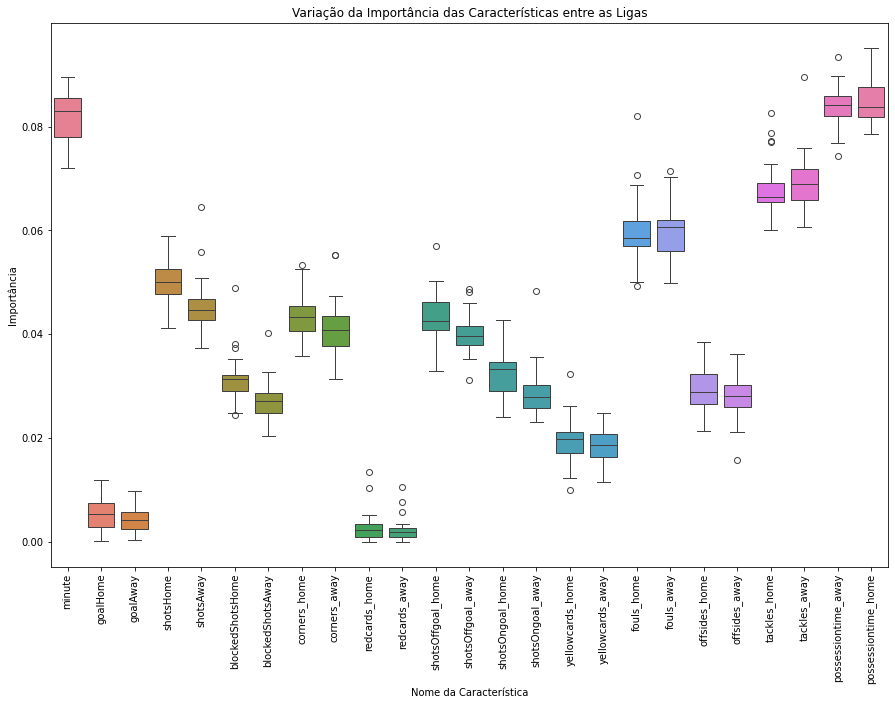

In [232]:
# Conversão do que ta no dataframe para lista
def convert_to_list(ndarray):
    # Verifica se o ndarray não é vazio e converte para lista
    return ndarray.tolist() if ndarray.size else []

importance_lists = dataframe_league['feature_importance'].apply(convert_to_list)

# Criando um DataFrame para armazenar os valores de importância para todas as ligas
feature_importance_df = pd.DataFrame(importance_lists.tolist())

# Calculando estatísticas descritivas para cada característica em todas as ligas
feature_importance_stats = feature_importance_df.describe()

# feature_names = summary_df['Feature Name'].tolist()

# Criar o gráfico de boxplot
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=feature_importance_df)
ax.set_title('Variação da Importância das Características entre as Ligas')
ax.set_xlabel('Nome da Característica')
ax.set_ylabel('Importância')
plt.xticks(ticks=np.arange(len(feature_names)), labels=feature_names, rotation=90)
plt.show()


- Variação na Importância: Características com boxplots mais largos indicam uma maior variação na sua importância entre as ligas. Isso sugere que o impacto dessas características é mais específico para cada liga. Por outro lado, características com boxplots mais estreitos mostram uma consistência maior, indicando que a importância dessas características é mais uniforme entre as ligas.
Outliers:

- Alguns boxplots têm pontos outliers, que representam ligas onde a importância da característica é notavelmente diferente do padrão observado na maioria das outras ligas. Esses outliers podem indicar casos específicos onde uma característica é particularmente mais ou menos relevante.

- Modelos Personalizados para Ligas: As características com maior variação (boxplots mais largos e/ou com outliers) são fortes candidatas a justificar a criação de modelos separados para cada liga. Isso permitiria que os modelos levassem em conta as peculiaridades de cada liga, resultando em previsões mais precisas.

- Características com menor variação podem ser tratadas de forma mais consistente entre os modelos para diferentes ligas.

# Engenharia de recursos

### Predicting Sports Results with Artificial Intelligence – A Proposal for Soccer Games
- Variáveis incluem gols, chutes, escanteios, força de ataque, desempenho de jogadores e técnicos, resultados históricos de jogos, e fatores como vantagem de jogar em casa, e o índice pi-rating, que considera o desempenho recente das equipes.
### Decentralized policy learning with partial observation and mechanical constraints for multiperson modeling - Keisuke Fujii
- As variáveis incluíram dados de localização dos jogadores (posição, velocidade, aceleração), resultados de jogos anteriores (como taxas de vitória e histórico de desempenho) e atributos individuais dos jogadores (como pontuação, assistências e rebotes).
### Stochastic Analysis of the Elo Rating Algorithm in Round-Robin Tournaments -  Daniel Gomes de Pinho Zanco, Leszek Szczecinski, Eduardo Vinicius Kuhn e Rui Seara
- Número de equipes, número total de jogos, indice de partida, habilidades das equipes, habilidades teóricas "verdadeiras", habilidades estimadas, vetor de programação, diferença entre as habilidades dos oponentes, resultado do jogo, parâmetro de tamanho de passo, vantagem de campo, variância de θ*, função logística, função densidade de probabilidade da distribuição logística, função de perda, matriz de autocorrelação de xk, desvio médio-quadrático das habilidades, comportamento médio da função de perda, limite inferior na média da função de perda, excesso médio de perda, constante de convergência no sentido médio, constante de convergência no sentido médio-quadrático, constante de tempo de convergência no sentido médio, constante de tempo de convergência no sentido médio-quadrático, limite que separa pequeno e grande v, valor ótimo do tamanho do passo para k jogos/partidas.
### Metodologia para Análise Preditiva de Resultados de Jogos Esportivos: Um Estudo de Caso por Jogos na NBA - Lourival Gonçalves Prata Netto
- Variáveis relacionadas às estatísticas de desempenho das equipes e jogadores, como eficiência ofensiva e defensiva, Net Rating (saldo de pontos de um time a cada 100 posses de bola), Pace (número médio de posses de bola por partida),  Além disso, são consideradas estatísticas individuais dos jogadores, refletindo o impacto deles nas eficiências ofensiva e defensiva da equipe. A pesquisa correlaciona meticulosamente essas variáveis com os resultados dos jogos para estabelecer modelos preditivos.
### Análise Preditiva em Partidas de Tênis - Suzana Barboza Carvalho
- Em “Ultimate Tennis Statistics” inclui estatísticas atualizadas dos jogadores e a “Tennis Abstract” oferecia uma base de dados consolidada sobre torneios e jogadores. O estudo analisou 169 atributos por jogador, categorizados em 18 grupos diferentes para gerenciar a complexidade e evitar o overfitting. Entre os atributos de performance analisados estão detalhes como nome do torneio, tipo de piso da quadra, nível do torneio, data, nomes dos jogadores, mão de domínio, idade, ranking, pontos de ranking, tie breaks decisivos, aces, duplas faltas, eficácia dos saques, pontos ganhos por game de serviço e retorno, break points enfrentados e ganhos, além de outras medidas de desempenho como tempo de ponto, games e sets por partida​​.
### Análise preditiva de fatores que influenciam na entrada na zona de finalização em partidas de futebol - Leandro Stival 
- Utilizados dados de 10 jogos completos, incluindo a posição de todos os jogadores a cada 30 frames por segundo. Eventos como faltas, gols e saídas pelas laterais também foram rotulados nos dados​​.
### Análise de desempenho esportivo baseada em dados estatísticos - Frederico Queiroz Nascimento 
- Variáveis incluem detalhes das partidas, como vencedor, localização (mandante ou visitante), finalizações, contra-ataques, ligação direta, posse de bola, cruzamentos, passes, percentual de vitórias por mando de campo, análise do desempenho de times específicos em campeonatos distintos, e avaliações de desempenho baseadas em combinações específicas de variáveis, como a correlação entre finalizações e posicionamento ou entre contra-ataques e ligação direta, enriquecendo a análise estratégica para os clubes de futebol.
### Análise do Jogo de Futebol: Padrões de Jogo Ofensivo em Equipas de Alto Rendimento - Uma Abordagem Qualitativa
- Padrões sequenciais de conduta, relações excitatórias entre condutas, e conceitos e filosofias de jogo extraídos das entrevistas
### Previsão de resultado de jogos da NBA com algoritmos de machine learning
- Variáveis relacionadas a pontuação, jogadas, e rastreamento dos jogadores e da bola. Inclui métricas como arremessos de quadra, rebotes, faltas, e lances livres.
### The Validity and Reliability of Live Football Match Statistics From Champdas Master Match Analysis System
- Desempenho relacionado ao ataque, passe e defesa/goleiro. Estas incluem: mudança de ataque, entrar no terço ofensivo, chute, chute a gol, posse ganha, duelo aéreo, passe bem-sucedido, passe para frente, passe em profundidade, passe lateral, passe diagonal, passe para trás, passe longo, passe curto, assistência, passe consecutivo, passe chave, cruzamento, desarme, interceptação, rebatida, passe bloqueado, chute bloqueado, defesa, soco, defesa desviada e goleiro saída. Estas variáveis abrangem aspectos relacionados ao ataque, passe e defesa/goleiro, oferecendo uma análise detalhada das ações durante as partidas.

In [233]:
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goalHome', 'goalAway', 'shotsHome',
       'shotsAway', 'blockedShotsHome', 'blockedShotsAway', 'league',
       'corners_home', 'corners_away', 'redcards_home', 'redcards_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home'],
      dtype='object')

In [234]:
df = pd.read_csv('data_trated.csv', encoding='utf-8')

# renomeando colunas para um padrao _home e _away
colunas = ['goal', 'shots', 'blockedShots' ]
for coluna in colunas:
    df.rename(columns={coluna+'Home': coluna+'_home'}, inplace=True)
    df.rename(columns={coluna+'Away': coluna+'_away'}, inplace=True)

# função de calculo de força de ataque e defesa
# maher foi o criador da formula que utiliza os gols marcados e sofridos para calcular a força de ataque e defesa
# ele utiliza a media de gols marcados e sofridos para calcular a força de ataque e defesa
# como o dataset são de jogos ao vivo, a abordagem utilizada foi o calculo de medias rolantes dos ultimos 10 jogos de cada time 
def calculate_maher_stats(df, home_team_col, away_team_col, home_goals_col, away_goals_col):
    df_cleaned = df.groupby('match_id').agg({
    'homeTeam': 'first',
    'awayTeam': 'first',
    'goal_home': 'max',
    'goal_away': 'max',
}).reset_index()
    
    # Ordenando os dados por match_id
    df_sorted = df_cleaned.sort_values(by='match_id')

    # Agrupando por time e match_id e calculando os gols acumulados
    df_grouped_home = df_sorted.groupby([home_team_col, 'match_id'])[home_goals_col].sum().reset_index()
    df_grouped_away = df_sorted.groupby([away_team_col, 'match_id'])[away_goals_col].sum().reset_index()

    # Calculando as médias rolantes para a força de ataque em casa (a)
    df_grouped_home['f_attack_home'] = df_grouped_home.groupby(home_team_col)[home_goals_col].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    # Calculando as médias rolantes para a força defensiva fora de casa (J)
    df_grouped_away['f_defensive_away'] = df_grouped_away.groupby(away_team_col)[away_goals_col].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    # Unindo as estatísticas de volta ao DataFrame original
    df_with_stats = df.merge(df_grouped_home[[home_team_col, 'match_id', 'f_attack_home']], on=[home_team_col, 'match_id'], how='left')
    df_with_stats = df_with_stats.merge(df_grouped_away[[away_team_col, 'match_id', 'f_defensive_away']], left_on=[away_team_col, 'match_id'], right_on=[away_team_col, 'match_id'], how='left')

    # agrupando por time e match_id e calculando os gols acumulados
    df_grouped_home = df_sorted.groupby([home_team_col, 'match_id'])[away_goals_col].sum().reset_index()
    df_grouped_away = df_sorted.groupby([away_team_col, 'match_id'])[home_goals_col].sum().reset_index()

    # Para 'y' e 'S', cruzamos os dados dos gols dos times adversários
    # Força Defensiva em Casa (y)
    df_grouped_home['f_defensive_home'] = df_grouped_home.groupby(home_team_col)[away_goals_col].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )
    # Força de Ataque Fora de Casa (S)v
    df_grouped_away['f_attack_away'] = df_grouped_away.groupby(away_team_col)[home_goals_col].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    # Unindo as estatísticas de volta ao DataFrame original
    df_with_stats = df_with_stats.merge(df_grouped_home[[home_team_col, 'match_id', 'f_defensive_home']], on=[home_team_col, 'match_id'], how='left')
    df_with_stats = df_with_stats.merge(df_grouped_away[[away_team_col, 'match_id', 'f_attack_away']], left_on=[away_team_col, 'match_id'], right_on=[away_team_col, 'match_id'], how='left')
    
    return df_with_stats

df = calculate_maher_stats(df, 'homeTeam', 'awayTeam', 'goal_home', 'goal_away')
df.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away',
       'shots_home', 'shots_away', 'blockedShots_home', 'blockedShots_away',
       'league', 'corners_home', 'corners_away', 'redcards_home',
       'redcards_away', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'shotsOngoal_away', 'yellowcards_home',
       'yellowcards_away', 'fouls_home', 'fouls_away', 'offsides_home',
       'offsides_away', 'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'f_attack_home',
       'f_defensive_away', 'f_defensive_home', 'f_attack_away'],
      dtype='object')

In [235]:
# Obter o resultado final de cada jogo
final_results = df.drop_duplicates(subset=['match_id'], keep='last')

# Determinar o resultado final de cada jogo
final_results['final_result'] = (final_results['goal_home'] - final_results['goal_away']).apply(lambda x: 1 if x > 0 else -1 if x < 0 else 0)

# Inicializar colunas para vitória, derrota e empate para time da casa e visitante
final_results['home_win'] = final_results['final_result'] == 1
final_results['away_win'] = final_results['final_result'] == -1
final_results['home_loss'] = final_results['final_result'] == -1
final_results['away_loss'] = final_results['final_result'] == 1
final_results['home_draw'] = final_results['final_result'] == 0
final_results['away_draw'] = final_results['final_result'] == 0

# Calcular as taxas de vitoria, empate e derrota para cada time
# uma das abordagens mais utilizadas para previsão de resultados de futebol é a utilização de taxas de vitoria, empate e derrota
# como o dataset são de jogos ao vivo, a abordagem utilizada foi o calculo de medias rolantes dos ultimos 10 jogos de cada time 
def calculate_team_rates(df, home_or_away):
    team_results = df.groupby([f'{home_or_away}Team', 'match_id']).agg(
        win=(f'{home_or_away}_win', 'max'),
        loss=(f'{home_or_away}_loss', 'max'),
        draw=(f'{home_or_away}_draw', 'max')
    ).reset_index()

    team_results['win_rate'] = team_results.groupby(f'{home_or_away}Team')['win'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )
    team_results['loss_rate'] = team_results.groupby(f'{home_or_away}Team')['loss'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )
    team_results['draw_rate'] = team_results.groupby(f'{home_or_away}Team')['draw'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )

    return team_results

# Calculando as taxas para cada time em casa e fora
home_rates = calculate_team_rates(final_results, 'home')
away_rates = calculate_team_rates(final_results, 'away')

# Renomeando colunas para mesclar
home_rates.rename(columns={'win_rate': 'win_rate_home', 'loss_rate': 'loss_rate_home', 'draw_rate': 'draw_rate_home'}, inplace=True)
away_rates.rename(columns={'win_rate': 'win_rate_away', 'loss_rate': 'loss_rate_away', 'draw_rate': 'draw_rate_away'}, inplace=True)

# Mesclar as taxas calculadas para cada time em casa e fora com o DataFrame final_results
merged_rates = final_results.merge(home_rates[['match_id', 'win_rate_home', 'loss_rate_home', 'draw_rate_home']], on='match_id', how='left')
merged_rates = merged_rates.merge(away_rates[['match_id', 'win_rate_away', 'loss_rate_away', 'draw_rate_away']], on='match_id', how='left')

# Agora, vamos mesclar as taxas calculadas com o DataFrame original
final_data_with_all_info = df.merge(merged_rates[['match_id', 'win_rate_home', 'loss_rate_home', 'draw_rate_home', 'win_rate_away', 'loss_rate_away', 'draw_rate_away']], 
                                      on='match_id', how='left')

final_data_with_all_info.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away',
       'shots_home', 'shots_away', 'blockedShots_home', 'blockedShots_away',
       'league', 'corners_home', 'corners_away', 'redcards_home',
       'redcards_away', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'shotsOngoal_away', 'yellowcards_home',
       'yellowcards_away', 'fouls_home', 'fouls_away', 'offsides_home',
       'offsides_away', 'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'f_attack_home',
       'f_defensive_away', 'f_defensive_home', 'f_attack_away',
       'win_rate_home', 'loss_rate_home', 'draw_rate_home', 'win_rate_away',
       'loss_rate_away', 'draw_rate_away'],
      dtype='object')

Em 'A League-Wide Evaluation of Factors Influencing Match Activity Profile in Elite Australian Football', Esmaeili, Clifton e Aughey (2020) destacam a complexidade e a multifatorialidade do desempenho em jogos de futebol de elite. As medidas de desempenho utilizadas para o sistema de análise de partidas 'Champdas Master System' foram divididas em 
- Desempenho relacionado ao ataque
- Desempenho relacionado com passes
- Desempenho relacionado com Defesa

Nos dados, as estatisticas,
- de ataque são: shotsOngoal, shotsOffGoal, corners
- relacionada a passes: possessiontime
- relacionado a defesa: tackles, blockedShots

Anotações: Essas variáveis do artigo foram utilizadas para interpretar o impacto com os proprios dados do jogo. O trabalho presente avalia essas características como variáveis preditoras

In [236]:
def calculate_efficiency_attack(df):
    df['shotAccuracy_home'] = df['shotsOngoal_home'] / (df['shots_home'] + 0.01)
    df['shotAccuracy_away'] = df['shotsOngoal_away'] / (df['shots_away'] + 0.01)

def calculate_defense_performance(df):
    df['attackPressureOverTime_home'] = (df['shots_home'] + df['corners_home']) / df['minute']
    df['attackPressureOverTime_away'] = (df['shots_away'] + df['corners_away']) / df['minute']

    df['aggrressionOverTime_home'] = (df['redcards_home'] + df['yellowcards_home'] + df['fouls_home']) / df['minute']
    df['aggresssionOverTime_away'] = (df['redcards_away'] + df['yellowcards_away'] + df['fouls_away']) / df['minute']

    df['defensiveEfficacy_home'] = df['blockedShots_home'] / (df['shotsOngoal_home'] + 0.01) # chutes que foram bloqueados e chutes que foram no gol da equipe adversaria
    df['defensiveEfficacy_away'] = df['blockedShots_away'] / (df['shotsOngoal_away'] + 0.01) 

    df['taklesOverTime_home'] = df['tackles_home'] / df['minute']
    df['taklesOverTime_away'] = df['tackles_away'] / df['minute']

def calculate_passing_performance(df):
    df['possessionControl'] = abs(df['possessiontime_home'] - df['possessiontime_away'])
    df['passRisk_home'] = df['offsides_home'] / (df['possessiontime_home'] + 0.01)
    df['passRisk_away'] = df['offsides_away'] / (df['possessiontime_away'] + 0.01)

def calculate_cards(df):
    df['TotalCards_home'] = df['redcards_home'] + df['yellowcards_home']
    df['TotalCards_away'] = df['redcards_away'] + df['yellowcards_away']

# Aplicando as funções
calculate_efficiency_attack(final_data_with_all_info)
calculate_defense_performance(final_data_with_all_info)
calculate_passing_performance(final_data_with_all_info)
calculate_cards(final_data_with_all_info)

final_data_with_all_info.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away',
       'shots_home', 'shots_away', 'blockedShots_home', 'blockedShots_away',
       'league', 'corners_home', 'corners_away', 'redcards_home',
       'redcards_away', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'shotsOngoal_away', 'yellowcards_home',
       'yellowcards_away', 'fouls_home', 'fouls_away', 'offsides_home',
       'offsides_away', 'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'f_attack_home',
       'f_defensive_away', 'f_defensive_home', 'f_attack_away',
       'win_rate_home', 'loss_rate_home', 'draw_rate_home', 'win_rate_away',
       'loss_rate_away', 'draw_rate_away', 'shotAccuracy_home',
       'shotAccuracy_away', 'attackPressureOverTime_home',
       'attackPressureOverTime_away', 'aggrressionOverTime_home',
       'aggresssionOverTime_away', 'defensiveEfficacy_home',
       'defensiveEfficacy_away', 'taklesOverTi

### Características das variáveis dos dados
- gols: goalHome, goalAway
- chutes: shotsHome, shotsAway, blockedShotsHome, blockedShotsAway, shotsOffgoal_home, shotsOffgoal_away, shotsOngoal_home, shotsOngoal_away
- escanteios: corners_home, corners_away

- força de ataque: 'f_attack_home', 'f_defensive_away', 'f_defensive_home', 'f_attack_away'
        
- resultados históricos: desempenho recente das equipes (últimos 10 jogos): 
        taxa de vitória/derrota, 
        taxa de gols marcados em cada tempo: 
                mais de um gol no primeiro tempo (05ht_home e 05ht_away), 
                mais de dois gols marcados no primeiro tempo (15ht_home e 15ht_away), 
                mais de tres gols marcados no primeiro tempo (25ht_home e 25ht_away),
                mais de um gol marcado no segundo tempo (05ft_home e 05ft_away), 
                mais de dois gols marcado no segundo tempo (15ft_home e 15ft_away), 
                mais de tres gols marcados no segundo tempo (25ft_home e 25ft_away),
                mais de um gol marcado nos dois tempos (05_home e 05_away),
                mais de dois gol marcado nos dois tempos (15_home e 15_away),
                mais de tres gol marcado nos dois tempos (25_home e 25_away),
                

- eficiência ofensiva: shotsOnGoalEfficiency, attackPressure, shotAccuracy_home, shotAccuracy_away
- eficiência defenciva: possessionControl, passRiskHome, passRiskAway, defensiveDiscipline, defensiveEfficacy, defensiveAggression

In [237]:
# Expandido a função para calcular as estatísticas baseada no histórico dos ultimos 10 jogos de cada time
# Função para calcular as estatísticas dinâmicas
def calculate_expanded_stats(df, team_column, goal_column):
    # Ordenando os dados
    df_sorted = df.sort_values(by=['match_id', 'minute'])

    # Calculando os gols em cada tempo
    df_sorted['first_half_goals'] = df_sorted[goal_column].where(df_sorted['minute'] <= 45, 0)
    df_sorted['second_half_goals'] = df_sorted[goal_column].where(df_sorted['minute'] > 45, 0)

    # diminuindo gol do segundo tempo pelo gol do primeiro tempo
    df_sorted['second_half_goals'] = df_sorted['second_half_goals'] - df_sorted['first_half_goals']

    # Agrupando por time e match_id e calculando os gols cumulativos
    df_grouped = df_sorted.groupby([team_column, 'match_id']).agg(
        cum_first_half_goals=pd.NamedAgg(column='first_half_goals', aggfunc='max'),
        cum_second_half_goals=pd.NamedAgg(column='second_half_goals', aggfunc='max'),
        cum_full_game_goals=pd.NamedAgg(column=goal_column, aggfunc='max')
    ).reset_index()

    # Calculando as estatísticas rolantes para os últimos 10 jogos, excluindo o jogo atual
    stats_columns = {
        '05ht': lambda x: (x >= 1).mean(),
        '15ht': lambda x: (x >= 2).mean(),
        '25ht': lambda x: (x >= 3).mean(),
        '05ft': lambda x: (x >= 1).mean(),
        '15ft': lambda x: (x >= 2).mean(),
        '25ft': lambda x: (x >= 3).mean(),
        '05': lambda x: (x >= 1).mean(),
        '15': lambda x: (x >= 2).mean(),
        '25': lambda x: (x >= 3).mean()
    }

    for key, func in stats_columns.items():
        if 'ht' in key:
            df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_first_half_goals'].transform(
                lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
            )
        elif 'ft' in key:
            df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_second_half_goals'].transform(
                lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
            )
        else:
            df_grouped[f'{key}'] = df_grouped.groupby(team_column)['cum_full_game_goals'].transform(
                lambda x: x.rolling(window=10, min_periods=1).apply(lambda y: func(y.head(10)), raw=False)
            )

    # Mantendo apenas as colunas relevantes
    cols_to_keep = [team_column, 'match_id'] + [f'{key}' for key in stats_columns.keys()]
    df_stats = df_grouped[cols_to_keep]

    return df_stats

# Calculando as estatísticas expandidas para os times de casa e visitantes
home_expanded_stats = calculate_expanded_stats(final_data_with_all_info, 'homeTeam', 'goal_home')
away_expanded_stats = calculate_expanded_stats(final_data_with_all_info, 'awayTeam', 'goal_away')

# Unindo as novas estatísticas de volta ao DataFrame original
df_with_expanded_stats = final_data_with_all_info.merge(home_expanded_stats, how='left', on=['homeTeam', 'match_id'])
df_with_expanded_stats = df_with_expanded_stats.merge(away_expanded_stats, how='left', left_on=['awayTeam', 'match_id'], right_on=['awayTeam', 'match_id'])

# Removendo os sufixos _x e _y e renomeando as colunas corretamente
df_with_expanded_stats.columns = [col.replace('_x', '_home').replace('_y', '_away') for col in df_with_expanded_stats.columns]

# Verificando as alterações
df_with_expanded_stats.columns

Index(['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away',
       'shots_home', 'shots_away', 'blockedShots_home', 'blockedShots_away',
       'league', 'corners_home', 'corners_away', 'redcards_home',
       'redcards_away', 'shotsOffgoal_home', 'shotsOffgoal_away',
       'shotsOngoal_home', 'shotsOngoal_away', 'yellowcards_home',
       'yellowcards_away', 'fouls_home', 'fouls_away', 'offsides_home',
       'offsides_away', 'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'f_attack_home',
       'f_defensive_away', 'f_defensive_home', 'f_attack_away',
       'win_rate_home', 'loss_rate_home', 'draw_rate_home', 'win_rate_away',
       'loss_rate_away', 'draw_rate_away', 'shotAccuracy_home',
       'shotAccuracy_away', 'attackPressureOverTime_home',
       'attackPressureOverTime_away', 'aggrressionOverTime_home',
       'aggresssionOverTime_away', 'defensiveEfficacy_home',
       'defensiveEfficacy_away', 'taklesOverTi

In [238]:
# # SC Corinthians Paulista
# df_with_expanded_stats[df_with_expanded_stats['homeTeam'] == 'SC Corinthians Paulista'].drop_duplicates(subset=['match_id'], keep='last')[['minute', 'homeTeam', 
#                                                                                                    'awayTeam', 'goal_home', 'goal_away', 
#                                                                                                    '05ht_home', '15ht_home', '25ht_home',
#        '05ft_home', '15ft_home', '25ft_home', '05_home', '15_home', '25_home',
#        '05ht_away', '15ht_away', '25ht_away', '05ft_away', '15ft_away',
#        '25ft_away', '05_away', '15_away', '25_away']].to_csv('maher_stats.csv', index=False)

In [239]:
# Botafogo FC Ribeirão Preto
# df[df['homeTeam'] == 'Botafogo FC Ribeirão Preto'].drop_duplicates(subset=['match_id'], keep='last')[['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away', 'f_attack_home', 'f_defensive_away', 'f_defensive_home', 'f_attack_away']].to_csv('maher_stats.csv', index=False)

In [240]:
# df_with_expanded_stats.columns

In [241]:
# df_with_expanded_stats[df_with_expanded_stats['homeTeam'] == 'SC Corinthians Paulista'][['minute', 'homeTeam', 'awayTeam', 'goal_home', 'goal_away', '05ht_home', '15ht_home', '25ht_home',
#        '05ft_home', '15ft_home', '25ft_home', '05_home', '15_home', '25_home',
#        '05ht_away', '15ht_away', '25ht_away', '05ft_away', '15ft_away',
#        '25ft_away', '05_away', '15_away', '25_away']].head(1000).to_csv('data_teste.csv', index=False, encoding='utf-8')

In [242]:
# df_with_expanded_stats

In [243]:
# df_with_expanded_stats.head(1000).to_csv('data_teste.csv', index=False, encoding='utf-8')

In [244]:

# def calculate_event_change(data, event_column, lookback=10):
#     """
#     Calcula a mudança no evento especificado para cada linha, olhando para os 
#     10 registros anteriores. A diferença entre os valores máximo e mínimo nesse
#     intervalo é calculada.
#     """
#     # Nome da nova coluna
#     new_column = f'total_change_{event_column}'

#     # Calculando o valor máximo e mínimo em uma janela deslizante
#     rolling_max = data[event_column].rolling(window=lookback, min_periods=1).max()
#     rolling_min = data[event_column].rolling(window=lookback, min_periods=1).min()

#     # Calculando a diferença e atribuindo à nova coluna
#     data[new_column] = rolling_max - rolling_min

#     return data

# # Aplicando a função ao dataframe_league 'data_teste' para a coluna os eventos
# # Criando uma cópia do data_copyframe original para trabalhar com as mudanças
# data = Xht.copy()
# for event_column in event_columns:
#     Xht = calculate_event_change(data, event_column)

In [245]:
df = df_with_expanded_stats.copy()

Contando partidas por time...
Total de partidas: 8591

Filtrando dados de ligas...
Dados filtrados:

league
USA - Major League Soccer            18985
Brazil - Serie A                     16988
Argentina - Superliga                16215
England - Championship               16060
Spain - La Liga 2                    14101
England - League Two                 13025
England - League One                 12663
Japan - J-League                     11977
Mexico - Liga MX                     10061
Spain - La Liga                      10037
Italy - Serie B                       9309
Europe - Champions League             8251
South America - Copa Libertadores     8185
France - Ligue 1                      7970
England - Premier League              7940
Asia - AFC Champions League           7806
Europe - Europa League                7760
Europe - UEFA Nations League          7487
Saudi Arabia - Pro League             7392
Italy - Serie A                       7361
South America - Copa Sudamerican

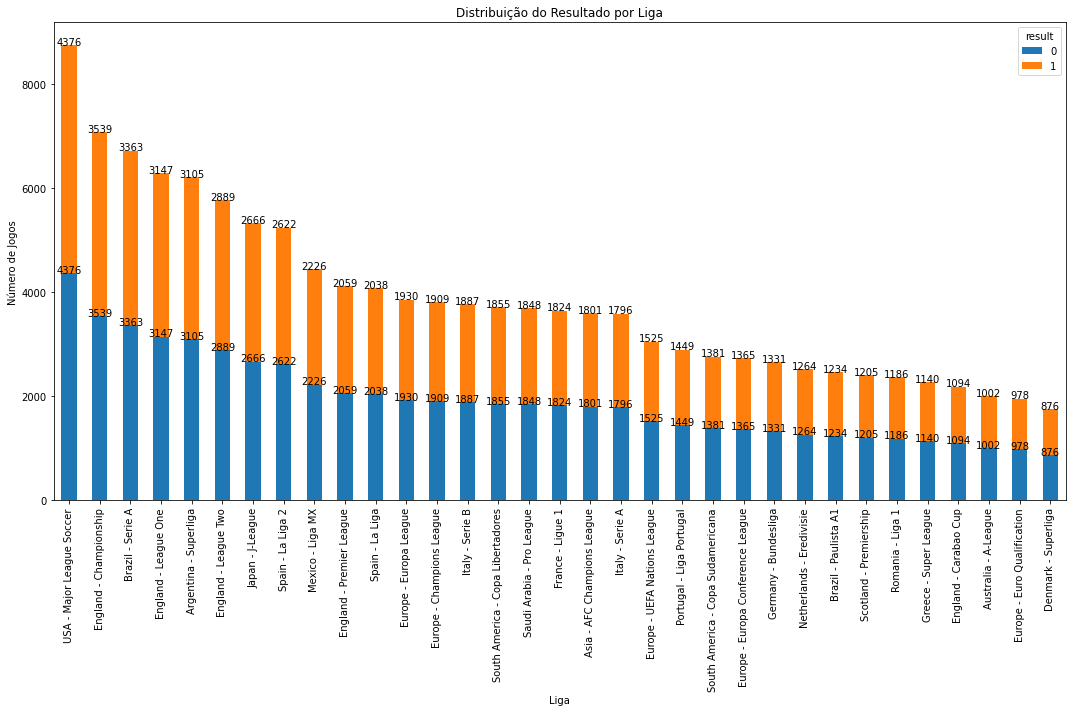

<Figure size 432x288 with 0 Axes>

In [247]:
# Função para filtrar ligas com base no número mínimo de partidas
def filter_leagues(df, league_col, matches, min_matches=100):
    # Agrupa o DataFrame por liga e conta o número único de partidas para cada liga
    league_game_counts = df.groupby(league_col)[matches].nunique()
    # Filtra para manter apenas as ligas com um número de partidas igual ou maior que min_matches
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    # Filtra o DataFrame original para incluir apenas linhas das ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

#     return balanced_data

def balance_data(df, league_col='league', result_col='result'):
    leagues = df[league_col].unique()
    # Lista para armazenar os DataFrames balanceados para cada liga
    balanced_dfs = []

    # Itera sobre cada liga para balancear os dados
    for league in leagues:
        # Filtra o DataFrame para incluir apenas dados da liga atual
        league_df = df[df[league_col] == league]
        # Selecionando os registros onde 'result' é 1
        result_1 = league_df[league_df[result_col] == 1]

        # Contando os minutos únicos e suas ocorrências em 'result' 1
        minutes_counts = result_1['minute'].value_counts()

        # Selecionando registros onde 'result' é 0
        result_0_sample = pd.DataFrame()
        for minute, count in minutes_counts.items():
            sample = league_df[(league_df['result'] == 0) & (league_df['minute'] == minute)].sample(n=count, replace=True, random_state=42)
            result_0_sample = pd.concat([result_0_sample, sample])

        # Combinando os dois conjuntos de dados para formar um novo dataframe balanceado
        balanced_dfs.append(pd.concat([result_1, result_0_sample]))
    
    # Combina todos os DataFrames balanceados em um único DataFrame
    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_data


print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")

balanced_data = balance_data(filtered_data)

print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [248]:
# Ordenando o DataFrame
df.sort_values(by=['match_id', 'minute'], inplace=True)

In [249]:
balanced_data.reset_index(drop=True, inplace=True)

In [250]:
balanced_data.value_counts('result')

result
0    63910
1    63910
Name: count, dtype: int64

In [251]:
balanced_data.to_csv("data_live_engineer.csv", index=False, encoding="utf-8")

In [252]:
balanced_data

,minute,homeTeam,awayTeam,goal_home,goal_away,shots_home,shots_away,blockedShots_home,blockedShots_away,league,...,25_home,05ht_away,15ht_away,25ht_away,05ft_away,15ft_away,25ft_away,05_away,15_away,25_away
0,36,Carabobo FC,Club Universitario de Deportes,0.0,0.0,3.0,10.0,2.0,3.0,South America - Copa Libertadores,...,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0
1,37,Carabobo FC,Club Universitario de Deportes,0.0,0.0,3.0,11.0,2.0,3.0,South America - Copa Libertadores,...,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0
2,38,Carabobo FC,Club Universitario de Deportes,0.0,0.0,3.0,11.0,2.0,3.0,South America - Copa Libertadores,...,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0
3,39,Carabobo FC,Club Universitario de Deportes,0.0,0.0,3.0,11.0,2.0,3.0,South America - Copa Libertadores,...,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0
4,40,Carabobo FC,Club Universitario de Deportes,0.0,0.0,3.0,11.0,2.0,3.0,South America - Copa Libertadores,...,0.0,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127815,87,Belarus,Romania,0.0,0.0,9.0,17.0,2.0,3.0,Europe - Euro Qualification,...,0.0,0.200000,0.0,0.0,0.100,0.0,0.0,0.300000,0.0,0.0
127816,87,Albania,Faroe Islands,0.0,0.0,8.0,8.0,2.0,2.0,Europe - Euro Qualification,...,0.0,0.333333,0.0,0.0,0.000,0.0,0.0,0.333333,0.0,0.0
127817,59,Iceland,Portugal,0.0,0.0,5.0,9.0,0.0,4.0,Europe - Euro Qualification,...,0.0,0.500000,0.0,0.0,0.125,0.0,0.0,0.625000,0.0,0.0
127818,88,Belarus,Romania,0.0,0.0,9.0,18.0,2.0,3.0,Europe - Euro Qualification,...,0.0,0.200000,0.0,0.0,0.100,0.0,0.0,0.300000,0.0,0.0
